In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h=fits.getdata('/Users/lpr/Desktop/11054_best_model.fits',1)
print(h.columns)

ColDefs(
    name = 'wavelength'; format = 'D'; unit = 'nm'
    name = 'Fnu'; format = 'D'; unit = 'mJy'
    name = 'L_lambda_total'; format = 'D'; unit = 'nm-1 W'
    name = 'stellar.old'; format = 'D'; unit = 'nm-1 W'
    name = 'stellar.young'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.absorption_old'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.absorption_young'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.lines_old'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.lines_young'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.continuum_old'; format = 'D'; unit = 'nm-1 W'
    name = 'nebular.continuum_young'; format = 'D'; unit = 'nm-1 W'
    name = 'attenuation.stellar.old'; format = 'D'; unit = 'nm-1 W'
    name = 'attenuation.stellar.young'; format = 'D'; unit = 'nm-1 W'
    name = 'attenuation.nebular.lines_old'; format = 'D'; unit = 'nm-1 W'
    name = 'attenuation.nebular.lines_young'; format = 'D'; unit = 'nm-1 W'
    name = 'attenuation.nebular.contin

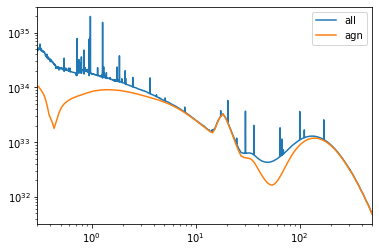

In [15]:
plt.loglog(h['wavelength'][(h['wavelength']>300)&(h['wavelength']<5e5)]/1e3,h['L_lambda_total'][(h['wavelength']>300)&(h['wavelength']<5e5)],nonpositive="clip",label='all')
plt.loglog(h['wavelength'][(h['wavelength']>300)&(h['wavelength']<5e5)]/1e3,h['agn.fritz2006_torus'][(h['wavelength']>300)&(h['wavelength']<5e5)]+h['agn.fritz2006_polar_dust'][(h['wavelength']>300)&(h['wavelength']<5e5)]+h['agn.fritz2006_disk'][(h['wavelength']>300)&(h['wavelength']<5e5)],nonpositive="clip",label='agn')
plt.xlim(0.3,500)
plt.legend()

array([0.9751243 , 0.97503331, 0.97502849, ..., 0.98940888, 0.98945122,
       0.98949473])

In [24]:
import scipy.integrate as inte
torus = h['agn.fritz2006_torus'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]
polar_dust = h['agn.fritz2006_polar_dust'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]
disk = h['agn.fritz2006_disk'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]
total = h['l_lambda_total'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]
wave = h['wavelength'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]
# (integrate.simpson(,h['wavelength'][(h['wavelength']>8e3)&(h['wavelength']<1e6)])+(integrate.simpson(,h['wavelength'][(h['wavelength']>8e3)&(h['wavelength']<1e6)])+(integrate.simpson(,h['wavelength'][(h['wavelength']>8e3)&(h['wavelength']<1e6)]))

In [1]:
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM as flcdm
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import ndimage
from scipy import stats
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy import stats
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.integrate import quad

In [2]:
hdu1 = fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data
hdu2 = fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data
hdu3 = fits.open('/Users/lpr/Data/lirg_project/output/catalog_radec/egs_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits')[1].data

hdu1_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodsn_id.fits',1)
hdu2_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/goodss_id.fits',1)
hdu3_id = fits.getdata('/Users/lpr/Data/lirg_project/output/catalog_radec/egs_id.fits',1)
hdu1 = hdu1[np.isin(hdu1['id'],hdu1_id['id'])]
hdu2 = hdu2[np.isin(hdu2['id'],hdu2_id['id'])]
hdu3 = hdu3[np.isin(hdu3['id'],hdu3_id['id'])]

In [14]:
hdu1_re = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/goodsn_re_hlr.fits',1)
hdu2_re = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/goodss_re_hlr.fits',1)
hdu3_re = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/egs_re_hlr.fits',1)

In [3]:
def kpc_per_arcsec(z):
    angular_distance = flcdm(H0=70,Om0=0.3).angular_diameter_distance(z).to_value()
    arc_scale = angular_distance*np.pi*1000/(180*3600)
    return(arc_scale)

In [5]:
# construct size mass relation according to van der Wel+14
def mass_size(mass,loga,alpha):
    m = (10**mass/10**10)/5
    re = (10**loga)*(m**alpha)
    return re
loga_early=[0.60,0.42,0.22,0.09,-0.05,-0.06]
alpha_early=[0.75,0.71,0.76,0.76,0.76,0.79]
loga_late=[0.86,0.78,0.70,0.65,0.55,0.51]
alpha_late=[0.25,0.22,0.22,0.23,0.22,0.18]
z_mass_size=[0.25,0.75,1.25,1.75,2.25,2.75]
def Da(z,H0,omega_matter):
    angular_distance = flcdm(H0=H0,Om0=omega_matter).angular_diameter_distance(z).to_value()
    return angular_distance
loga_early_9=interp1d(z_mass_size,loga_early)(0.9)
alpha_early_9=interp1d(z_mass_size,alpha_early)(0.9)
loga_late_9=interp1d(z_mass_size,loga_late)(0.9)
alpha_late_9=interp1d(z_mass_size,alpha_late)(0.9)
mass_late = np.linspace(9,11.4,100)
mass_early = np.linspace(10,11.4,100)
re_late_9 = (Da(0.9,71,0.27)/Da(0.9,70,0.3))**(2*alpha_late_9-1) * mass_size(mass_late,loga_late_9,alpha_late_9)
re_early_9 = (Da(0.9,71,0.27)/Da(0.9,70,0.3))**(2*alpha_early_9-1) * mass_size(mass_early,loga_early_9,alpha_early_9)
re_late_125 = (Da(1.25,71,0.27)/Da(1.25,70,0.3))**(2*0.22-1) * mass_size(mass_late,0.7,0.22)
re_early_125 = (Da(1.25,71,0.27)/Da(1.25,70,0.3))**(2*0.76-1) * mass_size(mass_early,0.22,0.76)
loga_early_1=interp1d(z_mass_size,loga_early)(1)
alpha_early_1=interp1d(z_mass_size,alpha_early)(1)
loga_late_1=interp1d(z_mass_size,loga_late)(1)
alpha_late_1=interp1d(z_mass_size,alpha_late)(1)
mass_late = np.linspace(9,11.4,100)
mass_early = np.linspace(10,11.4,100)
re_late_1 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_late_1-1) * mass_size(mass_late,loga_late_1,alpha_late_1)
re_early_1 = (Da(1,71,0.27)/Da(1,70,0.3))**(2*alpha_early_1-1) * mass_size(mass_early,loga_early_1,alpha_early_1)

<ipython-input-19-15b762a7d4d2>:27: RuntimeWarning: divide by zero encountered in log10
  l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
<ipython-input-19-15b762a7d4d2>:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max',location='top')#$SFR/SFR_{MS}$


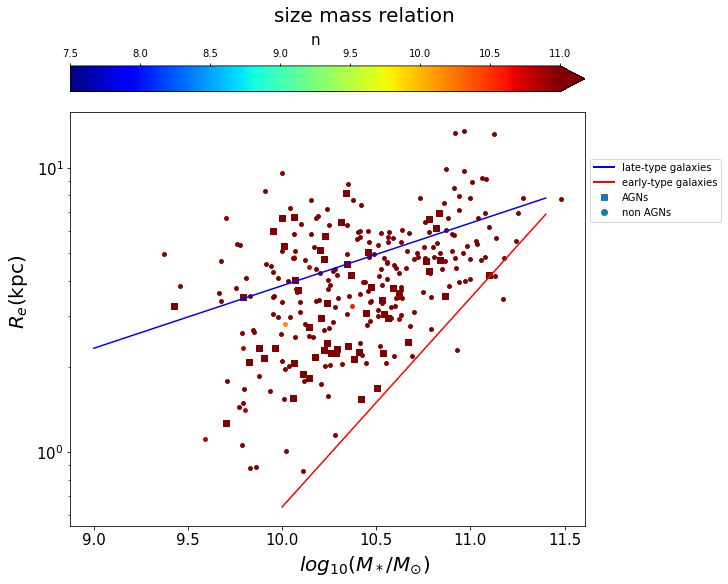

In [19]:
# size mass diagram
smallagn = np.array([11054, 19267, 11519, 23844, 27302, 12353, 13017707, 13004291]) #从sfr-re图上得到的logsfr>2，re<6kpc的星系，不全是agn
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=7.5,vmax=11)
fields_list = ['goodsn','goodss','egs']
root_path = '/Users/lpr/Data/lirg_project/output/catalog_radec/'
fig,axs = plt.subplots(1,1,figsize=[10,8],constrained_layout=True)#12.5,5
fig.supxlabel('$log_{10}(M_*/M_{\odot})$',fontsize=20)
fig.supylabel('$R_e$(kpc)',fontsize=20)
fig.suptitle('size mass relation',fontsize=20)
axs.plot(mass_early,re_early_1,color='red',label='early-type')
axs.plot(mass_late,re_late_1,color='blue',label='late-type')
axs.set_yscale('log')
pixel_scale= 0.06
for field in fields_list:
    id_ctg = fits.getdata(root_path+field+'_id.fits',1)
    all_catalog = fits.getdata(root_path+field+'_Huangall_candels_radec_van_zmasssfr8sfrhuangsfr.fits',1)
    all_catalog = all_catalog[np.isin(all_catalog['id'],id_ctg['id'])]
    re_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/van_re_half_light_radius/'+field+'_re_hlr.fits',1)
    subpsf_catalog = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/'+field+'_best_serisc.fits',1)
    for num1 in range(0,all_catalog.size):
        idx = all_catalog[num1]['id']
        lmass_candels = all_catalog[num1]['lmass_candels']
        z = all_catalog[num1]['z_used']
        sed_class = all_catalog[num1]['TMP_CLASS'][0]
        logsfr = np.log10(all_catalog[num1]['sfr_huang'])
        l4p5ex = np.log10(all_catalog[num1]['l4p5ex'])
        if idx in subpsf_catalog['id']:
            re = subpsf_catalog[subpsf_catalog['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
            n = subpsf_catalog[subpsf_catalog['id']==idx]['n_sersic'][0]
        else:
            re = re_catalog[re_catalog['id']==idx]['re'][0]*kpc_per_arcsec(z) 
            if re_catalog[re_catalog['id']==idx]['n_f160w'][0] != -99.:
                n=re_catalog[re_catalog['id']==idx]['n_f160w'][0]
            else:
                n=all_catalog[num1]['n_f160w']
#         if lmass_candels >10.5 and lmass_candels<11 and re>0.3 and re<1:
#             print(idx)
    #        if z>0.78 and z<=0.93:
    #            s0,m0,gama = [1.35,9.96,1.28]
    #        elif z>0.93 and z<=1.11:
    #            s0,m0,gama = [1.53,10.1,1.26]
    #        elif z>1.11 and z<=1.3:
    #            s0,m0,gama = [1.72,10.31,1.07]
    #        deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
        if sed_class==1:
            symbol = 's'
            size = 30
#             if idx in smallagn:
#                 symbol = '*'
#                 size = 105
#             else:
#                 symbol = 's'
#                 size = 30
        else:
            symbol = 'o'
            size = 15
        axs.scatter(lmass_candels,re,c=l4p5ex,marker=symbol,s=size,vmin=7.5,vmax=11,cmap='jet')
axs.tick_params(axis='both',labelsize=15)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),extend='max',location='top')#$SFR/SFR_{MS}$
cb.set_label(label='n',fontsize=15)
# legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='*',color='blue',label=r'disk AGNs'),Line2D([0],[0],lw=0,marker='*',color='red',label=r'bulge AGNs'),Line2D([0],[0],lw=0,marker='o',color='blue',label='disk galaxies'),Line2D([0],[0],lw=0,marker='o',color='red',label='bulge galaxies')]
legend_elements=[Line2D([0],[0],lw=2,color='b',label='late-type galaxies'),Line2D([0],[0],lw=2,color='r',label='early-type galaxies'),Line2D([0],[0],lw=0,marker='s',label='AGNs'),Line2D([0],[0],lw=0,marker='o',label='non AGNs')]
plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[1,0.9])
# fig.savefig('/Users/lpr/Data/lirg_project/output/images/size_mass_ncoded.pdf')

In [9]:
hdu1_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gdn_all_covermatch.fits')[1].data
hdu2_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/gds_all_vanmatch.fits')[1].data
hdu3_candels=fits.open('/Users/lpr/Data/lirg_project/intake/CANDELS/catalog/JFang_CANDELS_Data/egs_all_covermatch.fits')[1].data
hdu1_candels_copy = hdu1_candels[np.where((hdu1_candels['zbest']>=0.8)&(hdu1_candels['zbest']<=1.3)&(hdu1_candels['CLASS_STAR']<0.5)&(hdu1_candels['m_med']>=9.5)&(hdu1_candels['m_med']<=11.5))]
hdu2_candels_copy = hdu2_candels[np.where((hdu2_candels['zbest']>=0.8)&(hdu2_candels['zbest']<=1.3)&(hdu2_candels['CLASS_STAR']<0.5)&(hdu2_candels['m_med']>=9.5)&(hdu2_candels['m_med']<=11.5))]
hdu3_candels_copy = hdu3_candels[np.where((hdu3_candels['zbest']>=0.8)&(hdu3_candels['zbest']<=1.3)&(hdu3_candels['CLASS_STAR']<0.5)&(hdu3_candels['m_med']>=9.5)&(hdu3_candels['m_med']<=11.5))]

In [10]:
for num1 in range(0,len(hdu1_candels_copy)):
    hdu1_candels_copy[num1]['re_f160w'] = hdu1_candels_copy[num1]['re_f160w']*kpc_per_arcsec(hdu1_candels_copy[num1]['zbest'])
for num2 in range(0,len(hdu2_candels_copy)):
    hdu2_candels_copy[num2]['re_f160w'] = hdu2_candels_copy[num2]['re_f160w']*kpc_per_arcsec(hdu2_candels_copy[num2]['zbest'])
for num3 in range(0,len(hdu3_candels_copy)):
    hdu3_candels_copy[num3]['re_f160w'] = hdu3_candels_copy[num3]['re_f160w']*kpc_per_arcsec(hdu3_candels_copy[num3]['zbest'])

In [11]:
# re_can = np.concatenate((hdu1_candels_copy['re_f160w'],hdu3_candels_copy['re_f160w']),axis=0)
# logsfr_can = np.concatenate((np.log10(10**hdu1_candels_copy['ssfr_uv_corr']*10**hdu1_candels_copy['m_med']/1.06),np.log10(10**hdu3_candels_copy['ssfr_uv_corr']*10**hdu3_candels_copy['m_med']/1.06)),axis=0)
re_can = []
logsfr_can = []
for num1 in range(0,len(hdu1_candels_copy)):
    id_can = hdu1_candels_copy[num1]['id']
    if id_can not in hdu1['id_candels']:
        re_can.append(hdu1_candels_copy[num1]['re_f160w'])
        logsfr_can.append(np.log10(10**hdu1_candels_copy[num1]['ssfr_uv_corr']*10**hdu1_candels_copy[num1]['m_med']/1.06))
for num1 in range(0,len(hdu3_candels_copy)):
    id_can = hdu3_candels_copy[num1]['id']
    if id_can not in hdu3['id_candels']:
        re_can.append(hdu3_candels_copy[num1]['re_f160w'])
        logsfr_can.append(np.log10(10**hdu3_candels_copy[num1]['ssfr_uv_corr']*10**hdu3_candels_copy[num1]['m_med']/1.06))
re_can = np.array(re_can)
logsfr_can = np.array(logsfr_can)
h,xedges,yedges=np.histogram2d(re_can,logsfr_can,range=np.array([[0,15.],[0,3.]]),bins=np.array([20,20]))
# here to define the contour of 90% CANDELS data
percent = 0.89
temp = np.sort(h.flatten())[::-1]
count = np.sum(temp)
temp2 = 0
for num1 in range(0,len(temp)):
    temp2 += temp[num1]
    if temp2 > percent * count:
        break
cut1,pert1 = [temp[num1-1],(temp2-temp[num1])/count]
cut2,pert2 = [temp[num1],temp2/count]
f = interp1d([pert1,pert2],[cut1,cut2])
level_want = f(percent)

<a list of 1 text.Text objects>

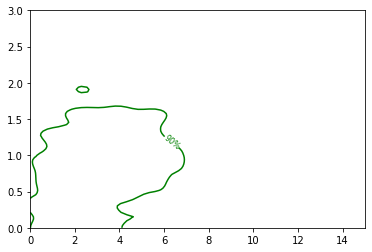

In [12]:
data = ndimage.zoom(h,[3,5])
x,y = np.linspace(xedges[0],xedges[-1],data.shape[0]),np.linspace(yedges[0],yedges[-1],data.shape[1])
contour = plt.contour(x,y,data.T,levels=[float(level_want)],colors=['green']) #xedges[0:xedges.shape[0]-1],yedges[0:yedges.shape[0]-1],h.T
plt.clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want):'90%'},use_clabeltext=True,inline_spacing=0)

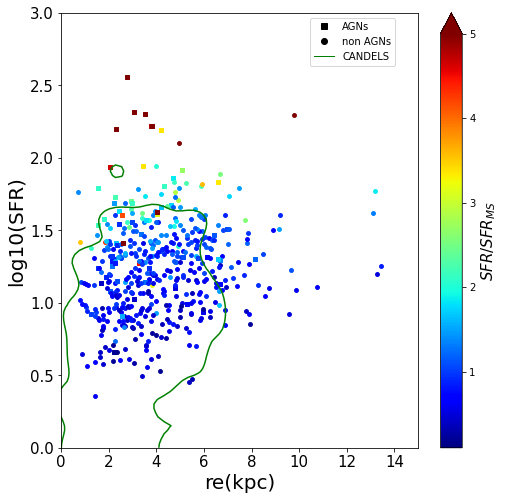

In [18]:
subpsf_catalog_1 = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/goodsn_best_serisc.fits',1)
subpsf_catalog_2 = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/goodss_best_serisc.fits',1)
subpsf_catalog_3 = fits.getdata('/Users/lpr/Data/lirg_project/output/subpsf/subpsf_xy_galfit/egs_best_serisc.fits',1)
from matplotlib.lines import Line2D
idx_list = []
param_list = []
symbols={1:'s',2:'o',3:'o',5:'o'}
symbols_pair = {True:'P',False:'*'}
color_pair = {True:'red',False:'blue'}
plt.figure(figsize=[8,8])
plt.contour(x,y,data.T,levels=[float(level_want)],colors=['green'])
plt.clabel(contour,contour.levels,inline=True,fontsize=8,fmt={1:'100%',float(level_want):'90%'},use_clabeltext=True,inline_spacing=0)
count = 0
for num1 in range(0,len(hdu1_candels_copy)):
    n = hdu1_candels_copy[num1]['n_f160w']
    id_can = hdu1_candels_copy[num1]['id']
for num1 in range(0,len(hdu3_candels_copy)):
    n = hdu3_candels_copy[num1]['n_f160w']
    id_can = hdu3_candels_copy[num1]['id']
for num2 in range(0,len(hdu1)):
    idx=hdu1[num2]['id']
    logsfr=np.log10(hdu1[num2]['sfr_huang'])
    tmp_class=hdu1[num2]['tmp_class'][0]
    z = hdu1[num2]['z_used']
    m = hdu1[num2]['lmass_candels']
#     count_spec = hdu1_pair[hdu1_pair['id']==idx]['count_spec'][0]
#     gini = hdu1_merger[hdu1_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu1_merger[hdu1_merger['id']==idx]['moment_20_statmorph']
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if hdu1_re[hdu1_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu1_re[hdu1_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu1[num2]['n_f160w']
    if idx in subpsf_catalog_1['id']:
        re = subpsf_catalog_1[subpsf_catalog_1['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
    else:
        re=hdu1_re[hdu1_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     if n>2 and n<=8:
#         color='red'
#     elif n<=2 and n>=0.2:
#         color='blue'
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         count+=1
#         color='red'
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         color='blue'
#     --------------------------------------------------------
#     plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])#,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
    plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=14,color=color)
    if re>0 and re<6 and logsfr>2:#re>=12:#
        idx_list.append(idx)
        param_list.append([re,logsfr])
for num2 in range(0,len(hdu2)):
    idx=hdu2[num2]['id']
    logsfr=np.log10(hdu2[num2]['sfr_huang'])
    tmp_class=hdu2[num2]['tmp_class'][0]
    z = hdu2[num2]['z_used']
    m = hdu2[num2]['lmass_candels']
#     count_spec = hdu2_pair[hdu2_pair['id']==idx]['count_spec'][0]
#     gini = hdu2_merger[hdu2_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu2_merger[hdu2_merger['id']==idx]['moment_20_statmorph']
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if hdu2_re[hdu2_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu2_re[hdu2_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu2[num2]['n_f160w']
    if idx in subpsf_catalog_2['id']:
        re = subpsf_catalog_2[subpsf_catalog_2['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
    else:
        re=hdu2_re[hdu2_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     if n>2 and n<=8:
#         color='red'
#     elif n<=2 and n>=0.2:
#         color='blue'
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         count+=1
#         color='red'
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         color='blue'
#     --------------------------------------------------------
#     plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])#,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
    plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=14,color=color)
    if re>0 and re<6 and logsfr>2:#re>=12:#
        idx_list.append(idx)
        param_list.append([re,logsfr])
for num2 in range(0,len(hdu3)):
    idx=hdu3[num2]['id']
    logsfr=np.log10(hdu3[num2]['sfr_huang'])
    tmp_class=hdu3[num2]['tmp_class'][0]
    z = hdu3[num2]['z_used']
    m = hdu3[num2]['lmass_candels']
#     count_spec = hdu3_pair[hdu3_pair['id']==idx]['count_spec'][0]
#     gini = hdu3_merger[hdu3_merger['id']==idx]['gini_coeff_statmorph']
#     m20 = hdu3_merger[hdu3_merger['id']==idx]['moment_20_statmorph']
#     main sequence parameters from lee+15
    if z>0.78 and z<=0.93:
        s0,m0,gama = [1.35,9.96,1.28]
    elif z>0.93 and z<=1.11:
        s0,m0,gama = [1.53,10.1,1.26]
    elif z>1.11 and z<=1.3:
        s0,m0,gama = [1.72,10.31,1.07]
    deltaMS = 10**(logsfr-(s0-np.log10(1+(10**m/10**m0)**(-1*gama))))
    if hdu3_re[hdu3_re['id']==idx]['n_f160w'][0] != -99.:
        n=hdu3_re[hdu3_re['id']==idx]['n_f160w'][0]
    else:
        n=hdu3[num2]['n_f160w']
    if idx in subpsf_catalog_3['id']:
        re = subpsf_catalog_3[subpsf_catalog_3['id']==idx]['re_sersic'][0]*pixel_scale*kpc_per_arcsec(z)
    else:
        re=hdu3_re[hdu3_re['id']==idx]['re'][0]*kpc_per_arcsec(z)
#     if n>2 and n<=8:
#         color='red'
#     elif n<=2 and n>=0.2:
#         color='blue'
#     if gini>-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         count+=1
#         color='red'
#     elif gini<-0.14*m20+0.33 and gini>0 and gini<1 and m20>-3 and m20<0:
#         color='blue'
#     --------------------------------------------------------
#     plt.scatter(re,logsfr,marker=symbols_pair[count_spec>0],s=20,color=color_pair[count_spec>0])#,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
    plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=deltaMS,cmap='jet',vmin=0.1,vmax=5)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=15,c=n,vmin=0.2,vmax=4,cmap='jet')#,norm=Norm_bound,cmap=cmap)
#     plt.scatter(re,logsfr,marker=symbols[tmp_class],s=14,color=color)
    if re>0 and re<6 and logsfr>2:#re>=12:#
        idx_list.append(idx)
        param_list.append([re,logsfr])
# plt.xlim(0,15)
# plt.xscale('log')
plt.ylim(0,3)
plt.ylabel('log10(SFR)',fontsize=20)
plt.xlabel('re(kpc)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cb = plt.colorbar(extend='max')#
cb.set_label('$SFR/SFR_{MS}$',fontsize=15)#
cb.ax.tick_params(labelsize=10)
legend_elements=[Line2D([0],[0],lw=0,marker='s',label=r'AGNs',color='black'),Line2D([0],[0],lw=0,marker='o',color='black',label=r'non AGNs'),Line2D([0],[0],lw=1,color='green',label=r'CANDELS')]
plt.legend(handles=legend_elements,fontsize=10,bbox_to_anchor=[0.95,1])
# legend_elements=[Line2D([0],[0],lw=0,marker='P',label='pair_spec',color='red'),Line2D([0],[0],lw=0,marker='*',color='blue',label='non pair')]
# plt.legend(handles=legend_elements,fontsize=10,loc='upper left',bbox_to_anchor=[0.7,0.2])
# plt.savefig('/Users/lpr/Data/lirg_project/output/images/resfr_radec_del_candels_n2coded.pdf')
plt.savefig('/Users/lpr/Data/lirg_project/output/images/resfr_radec_del_candels_MScoded.pdf')
# print(count/479)